### 数据准备

In [3]:
import torch
import random
import pandas as pd
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import os
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)

In [21]:
print(torch.__version__)

2.3.0a0+6ddf5cf85e.nv24.04


In [4]:
class UserItemRatingDataset(Dataset):
    """Wrapper, convert <user, item, rating> Tensor into Pytorch Dataset"""
    def __init__(self, user_tensor, item_tensor, target_tensor):
        """
        args:

            target_tensor: torch.Tensor, the corresponding rating for <user, item> pair
        """
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.user_tensor[index], self.item_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.user_tensor.size(0)

In [5]:
class SampleGenerator(object):
    """Construct dataset for NCF"""

    def __init__(self, ratings):
        """
        args:
            ratings: pd.DataFrame, which contains 4 columns = ['userId', 'itemId', 'rating', 'timestamp']
        """
        assert 'userId' in ratings.columns
        assert 'itemId' in ratings.columns
        assert 'rating' in ratings.columns

        self.ratings = ratings
        # explicit feedback using _normalize and implicit using _binarize
        # self.preprocess_ratings = self._normalize(ratings)
        self.preprocess_ratings = self._binarize(ratings)
        self.user_pool = set(self.ratings['userId'].unique())
        self.item_pool = set(self.ratings['itemId'].unique())
        # create negative item samples for NCF learning
        self.negatives = self._sample_negative(ratings)
        self.train_ratings, self.test_ratings = self._split_loo(self.preprocess_ratings)

    def _normalize(self, ratings):
        """normalize into [0, 1] from [0, max_rating], explicit feedback"""
        ratings = deepcopy(ratings)
        max_rating = ratings.rating.max()
        ratings['rating'] = ratings.rating * 1.0 / max_rating
        return ratings
    
    def _binarize(self, ratings):
        """binarize into 0 or 1, imlicit feedback"""
        ratings = deepcopy(ratings)
        ratings['rating'][ratings['rating'] > 0] = 1.0
        return ratings

    def _split_loo(self, ratings):
        """leave one out train/test split """
        ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)
        test = ratings[ratings['rank_latest'] == 1]
        train = ratings[ratings['rank_latest'] > 1]
        assert train['userId'].nunique() == test['userId'].nunique()
        return train[['userId', 'itemId', 'rating']], test[['userId', 'itemId', 'rating']]

    def _sample_negative(self, ratings):
        """return all negative items & 100 sampled negative items"""
        interact_status = ratings.groupby('userId')['itemId'].apply(set).reset_index().rename(
            columns={'itemId': 'interacted_items'})
        interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
        interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(list(x), 99))
        return interact_status[['userId', 'negative_items', 'negative_samples']]


    def instance_a_train_loader(self, num_negatives, batch_size):
        """instance train loader for one training epoch"""
        users, items, ratings = [], [], []
        train_ratings = pd.merge(self.train_ratings, self.negatives[['userId', 'negative_items']], on='userId')
        train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))
        for row in train_ratings.itertuples():
            users.append(int(row.userId))
            items.append(int(row.itemId))
            ratings.append(float(row.rating))
            for i in range(num_negatives):
                users.append(int(row.userId))
                items.append(int(row.negatives[i]))
                ratings.append(float(0))  # negative samples get 0 rating
        dataset = UserItemRatingDataset(user_tensor=torch.LongTensor(users),
                                        item_tensor=torch.LongTensor(items),
                                        target_tensor=torch.FloatTensor(ratings))
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    @property
    def evaluate_data(self):
        """create evaluate data"""
        test_ratings = pd.merge(self.test_ratings, self.negatives[['userId', 'negative_samples']], on='userId')
        test_users, test_items, negative_users, negative_items = [], [], [], []
        for row in test_ratings.itertuples():
            test_users.append(int(row.userId))
            test_items.append(int(row.itemId))
            for i in range(len(row.negative_samples)):
                negative_users.append(int(row.userId))
                negative_items.append(int(row.negative_samples[i]))
        return [torch.LongTensor(test_users), torch.LongTensor(test_items), torch.LongTensor(negative_users),
                torch.LongTensor(negative_items)]

In [6]:
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['userId', 'itemId', 'rating', 'timestamp'], engine='python')
print(ratings.head())

# 初始化 SampleGenerator
sample_generator = SampleGenerator(ratings)
train_loader = sample_generator.instance_a_train_loader(num_negatives=4, batch_size=256)
evaluate_data = sample_generator.evaluate_data

   userId  itemId  rating  timestamp
0       1    1193       5  978300760
1       1     661       3  978302109
2       1     914       3  978301968
3       1    3408       4  978300275
4       1    2355       5  978824291


/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


#### 方法库

In [7]:
# Checkpoints
def save_checkpoint(model, model_dir):
    torch.save(model.state_dict(), model_dir)

def resume_checkpoint(model, model_dir, device_id):
    device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
    state_dict = torch.load(model_dir, map_location=device)
    model.load_state_dict(state_dict)

def use_cuda(enabled, device_id=0):
    if enabled:
        assert torch.cuda.is_available(), 'CUDA is not available'
        torch.cuda.set_device(device_id)

def use_optimizer(network, params):
    if params['optimizer'] == 'sgd':
        optimizer = torch.optim.SGD(network.parameters(),
                                    lr=params['sgd_lr'],
                                    momentum=params['sgd_momentum'],
                                    weight_decay=params['l2_regularization'])
    elif params['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(network.parameters(),
                                     lr=params['adam_lr'],
                                     weight_decay=params['l2_regularization'])
    elif params['optimizer'] == 'rmsprop':
        optimizer = torch.optim.RMSprop(network.parameters(),
                                        lr=params['rmsprop_lr'],
                                        alpha=params['rmsprop_alpha'],
                                        momentum=params['rmsprop_momentum'])
    else:
        raise ValueError("Optimizer not recognized")
    return optimizer

### 模型准备

In [8]:
import math
import pandas as pd

class MetronAtK(object):
    def __init__(self, top_k):
        self._top_k = top_k
        self._subjects = None  # Subjects which we ran evaluation on

    @property
    def top_k(self):
        return self._top_k

    @top_k.setter
    def top_k(self, top_k):
        self._top_k = top_k

    @property
    def subjects(self):
        return self._subjects

    @subjects.setter
    def subjects(self, subjects):
        """
        args:
            subjects: list, [test_users, test_items, test_scores, negative users, negative items, negative scores]
        """
        assert isinstance(subjects, list)
        test_users, test_items, test_scores = subjects[0], subjects[1], subjects[2]
        neg_users, neg_items, neg_scores = subjects[3], subjects[4], subjects[5]
        test = pd.DataFrame({'user': test_users,
                             'test_item': test_items,
                             'test_score': test_scores})
        full = pd.DataFrame({'user': neg_users + test_users,
                            'item': neg_items + test_items,
                            'score': neg_scores + test_scores})
        full = pd.merge(full, test, on=['user'], how='left')
        # rank the items according to the scores for each user
        full['rank'] = full.groupby('user')['score'].rank(method='first', ascending=False)
        full.sort_values(['user', 'rank'], inplace=True)
        self._subjects = full

    def cal_hit_ratio(self):
        """Hit Ratio @ top_K"""
        full, top_k = self._subjects, self._top_k
        top_k = full[full['rank'] <= top_k]
        test_in_top_k = top_k[top_k['test_item'] == top_k['item']]  # golden items hit in the top_K items
        return len(test_in_top_k) * 1.0 / full['user'].nunique()

    def cal_ndcg(self):
        """NDCG @ top_K"""
        full, top_k = self._subjects, self._top_k
        top_k = full[full['rank'] <= top_k]
        test_in_top_k = top_k[top_k['test_item'] == top_k['item']]
        test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
        return test_in_top_k['ndcg'].sum() * 1.0 / full['user'].nunique()

In [9]:
import torch
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

class Engine(object):
    """Meta Engine for training & evaluating NCF model

    Note: Subclass should implement self.model !
    """

    def __init__(self, config):
        self.config = config  # model configuration
        self._metron = MetronAtK(top_k=10)
        self._writer = SummaryWriter(log_dir='runs/{}'.format(config['alias']))  # tensorboard writer
        self._writer.add_text('config', str(config), 0)
        self.opt = use_optimizer(self.model, config)
        self.crit = torch.nn.BCELoss()

    def train_single_batch(self, users, items, ratings):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        if self.config['use_cuda']:
            users, items, ratings = users.cuda(), items.cuda(), ratings.cuda()
        self.opt.zero_grad()
        ratings_pred = self.model(users, items)
        loss = self.crit(ratings_pred.view(-1), ratings)
        loss.backward()
        self.opt.step()
        return loss.item()

    def train_an_epoch(self, train_loader, epoch_id):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        self.model.train()
        total_loss = 0
        for batch_id, batch in enumerate(train_loader):
            user, item, rating = batch
            rating = rating.float()
            loss = self.train_single_batch(user, item, rating)
#             print(f'[Training Epoch {epoch_id}] Batch {batch_id}, Loss {loss}')
            total_loss += loss
        self._writer.add_scalar('model/loss', total_loss, epoch_id)

    def evaluate(self, evaluate_data, epoch_id):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        self.model.eval()
        with torch.no_grad():
            test_users, test_items = evaluate_data[0], evaluate_data[1]
            negative_users, negative_items = evaluate_data[2], evaluate_data[3]
            if self.config['use_cuda']:
                test_users, test_items = test_users.cuda(), test_items.cuda()
                negative_users, negative_items = negative_users.cuda(), negative_items.cuda()
            test_scores = self.model(test_users, test_items)
            negative_scores = self.model(negative_users, negative_items)
            if self.config['use_cuda']:
                test_users, test_items = test_users.cpu(), test_items.cpu()
                test_scores = test_scores.cpu()
                negative_users, negative_items = negative_users.cpu(), negative_items.cpu()
                negative_scores = negative_scores.cpu()
            self._metron.subjects = [test_users.tolist(),
                                     test_items.tolist(),
                                     test_scores.tolist(),
                                     negative_users.tolist(),
                                     negative_items.tolist(),
                                     negative_scores.tolist()]
        hit_ratio, ndcg = self._metron.cal_hit_ratio(), self._metron.cal_ndcg()
        self._writer.add_scalar('performance/HR', hit_ratio, epoch_id)
        self._writer.add_scalar('performance/NDCG', ndcg, epoch_id)
        print(f'[Evaluating Epoch {epoch_id}] HR = {hit_ratio:.4f}, NDCG = {ndcg:.4f}')
        return hit_ratio, ndcg

    def save(self, alias, epoch_id, hit_ratio, ndcg):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        model_dir = self.config['model_dir'].format(alias, epoch_id, hit_ratio, ndcg)
        save_checkpoint(self.model, model_dir)

##### GMF

In [10]:
class GMF(nn.Module):
    def __init__(self, config):
        super(GMF, self).__init__()
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.affine_output = nn.Linear(in_features=self.latent_dim, out_features=1)
        self.logistic = nn.Sigmoid()

        if config.get('weight_init_gaussian', False):
            for sm in self.modules():
                if isinstance(sm, (nn.Embedding, nn.Linear)):
                    torch.nn.init.normal_(sm.weight.data, 0.0, 0.01)

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating

class GMFEngine(Engine):
    """Engine for training & evaluating GMF model"""
    def __init__(self, config):
        self.model = GMF(config)
        if config['use_cuda']:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(GMFEngine, self).__init__(config)

##### MLP

In [11]:
class MLP(torch.nn.Module):
    def __init__(self, config):
        super(MLP, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=config['layers'][-1], out_features=1)
        self.logistic = torch.nn.Sigmoid()

        if config['weight_init_gaussian']:
            for sm in self.modules():
                if isinstance(sm, (nn.Embedding, nn.Linear)):
                    torch.nn.init.normal_(sm.weight.data, 0.0, 0.01)

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
        for idx in range(len(self.fc_layers)):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating

    def load_pretrain_weights(self):
        """Loading weights from trained GMF model"""
        config = self.config
        gmf_model = GMF(config)
        if config['use_cuda']:
            gmf_model.cuda()
        resume_checkpoint(gmf_model, model_dir=config['pretrain_mf'], device_id=config['device_id'])
        self.embedding_user.weight.data = gmf_model.embedding_user.weight.data
        self.embedding_item.weight.data = gmf_model.embedding_item.weight.data


class MLPEngine(Engine):
    """Engine for training & evaluating MLP model"""
    def __init__(self, config):
        self.model = MLP(config)
        if config['use_cuda']:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(MLPEngine, self).__init__(config)
        print(self.model)

        if config['pretrain']:
            self.model.load_pretrain_weights()

##### NeuMF
import torch
from gmf import GMF
from mlp import MLP
from engine import Engine
from utils import use_cuda, resume_checkpoint
from torch import nn

In [12]:
class NeuMF(torch.nn.Module):
    def __init__(self, config):
        super(NeuMF, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim_mf = config['latent_dim_mf']
        self.latent_dim_mlp = config['latent_dim_mlp']

        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp)
        self.embedding_user_mf = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)

        self.fc_layers = torch.nn.ModuleList()
        for in_size, out_size in zip(config['layers'][:-1], config['layers'][1:]):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=config['layers'][-1] + config['latent_dim_mf'], out_features=1)
        self.logistic = torch.nn.Sigmoid()

        if config['weight_init_gaussian']:
            for module in self.modules():
                if isinstance(module, (nn.Embedding, nn.Linear)):
                    torch.nn.init.normal_(module.weight.data, 0.0, 0.01)

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)

        for layer in self.fc_layers:
            mlp_vector = layer(mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating

    def load_pretrain_weights(self):
        """Loading weights from trained MLP model & GMF model"""
        config = self.config
        config['latent_dim'] = config['latent_dim_mlp']
        mlp_model = MLP(config)
        if config['use_cuda']:
            mlp_model.cuda()
        resume_checkpoint(mlp_model, model_dir=config['pretrain_mlp'], device_id=config['device_id'])

        self.embedding_user_mlp.weight.data = mlp_model.embedding_user.weight.data
        self.embedding_item_mlp.weight.data = mlp_model.embedding_item.weight.data
        for idx in range(len(self.fc_layers)):
            self.fc_layers[idx].weight.data = mlp_model.fc_layers[idx].weight.data

        config['latent_dim'] = config['latent_dim_mf']
        gmf_model = GMF(config)
        if config['use_cuda']:
            gmf_model.cuda()
        resume_checkpoint(gmf_model, model_dir=config['pretrain_mf'], device_id=config['device_id'])
        self.embedding_user_mf.weight.data = gmf_model.embedding_user.weight.data
        self.embedding_item_mf.weight.data = gmf_model.embedding_item.weight.data

        self.affine_output.weight.data = 0.5 * torch.cat([mlp_model.affine_output.weight.data, gmf_model.affine_output.weight.data], dim=-1)
        self.affine_output.bias.data = 0.5 * (mlp_model.affine_output.bias.data + gmf_model.affine_output.bias.data)

class NeuMFEngine(Engine):
    """Engine for training & evaluating NeuMF model"""
    def __init__(self, config):
        self.model = NeuMF(config)
        if config['use_cuda']:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(NeuMFEngine, self).__init__(config)
        print(self.model)

        if config['pretrain']:
            self.model.load_pretrain_weights()

#### 模型参数配置

In [11]:
import numpy as np

gmf_config = {
    'alias': 'gmf_factor8neg4-implict',
    'num_epoch': 60,
    'batch_size': 1024,
    'optimizer': 'adam',
    'adam_lr': 1e-3,
    'num_users': 6040,
    'num_items': 3706,
    'latent_dim': 8,
    'num_negative': 4,
    'l2_regularization': 0,
    'weight_init_gaussian': True,
    'use_cuda': torch.cuda.is_available(), 
    'device_id': 0,
    'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
}

mlp_config = {
    'alias': 'mlp_factor8neg4_bz256_166432168_pretrain_reg_0.0000001',
    'num_epoch': 60,
    'batch_size': 256,
    'optimizer': 'adam',
    'adam_lr': 1e-3,
    'num_users': 6040,
    'num_items': 3706,
    'latent_dim': 8,
    'num_negative': 4,
    'layers': [16, 64, 32, 16, 8],
    'l2_regularization': 0.0000001,
    'weight_init_gaussian': True,
    'use_cuda': torch.cuda.is_available(), 
    'device_id': 0,
    'pretrain': False,
    'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model'),
    'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
}

neumf_config = {
    'alias': 'neumf_factor8neg4',
    'num_epoch': 60,
    'batch_size': 1024,
    'optimizer': 'adam',
    'adam_lr': 1e-3,
    'num_users': 6040,
    'num_items': 3706,
    'latent_dim_mf': 8,
    'latent_dim_mlp': 8,
    'num_negative': 4,
    'layers': [16, 64, 32, 16, 8],
    'l2_regularization': 0.0000001,
    'weight_init_gaussian': True,
    'use_cuda': torch.cuda.is_available(), 
    'device_id': 0,
    'pretrain': False,
    'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model'),
    'pretrain_mlp': 'checkpoints/{}'.format('mlp_factor8neg4_Epoch100_HR0.5606_NDCG0.2463.model'),
    'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
}

#### 训练

In [13]:
import os

# Load Data
ml1m_dir = 'ml-1m/ratings.dat'
ml1m_rating = pd.read_csv(ml1m_dir, sep='::', header=None, names=['uid', 'mid', 'rating', 'timestamp'], engine='python')

# Reindex
user_id = ml1m_rating[['uid']].drop_duplicates().reset_index(drop=True)
user_id['userId'] = np.arange(len(user_id))
ml1m_rating = pd.merge(ml1m_rating, user_id, on=['uid'], how='left')

item_id = ml1m_rating[['mid']].drop_duplicates().reset_index(drop=True)
item_id['itemId'] = np.arange(len(item_id))
ml1m_rating = pd.merge(ml1m_rating, item_id, on=['mid'], how='left')

ml1m_rating = ml1m_rating[['userId', 'itemId', 'rating', 'timestamp']]
print('Range of userId is [{}, {}]'.format(ml1m_rating.userId.min(), ml1m_rating.userId.max()))
print('Range of itemId is [{}, {}]'.format(ml1m_rating.itemId.min(), ml1m_rating.itemId.max()))

sample_generator = SampleGenerator(ratings=ml1m_rating)
evaluate_data = sample_generator.evaluate_data

Range of userId is [0, 6039]
Range of itemId is [0, 3705]


In [14]:
# 记录结果的函数
def record_results(alias, epoch, hit_ratio, ndcg, results_dict):
    if alias not in results_dict:
        results_dict[alias] = {'epochs': [], 'hr': [], 'ndcg': []}
    results_dict[alias]['epochs'].append(epoch)
    results_dict[alias]['hr'].append(hit_ratio)
    results_dict[alias]['ndcg'].append(ndcg)

results = {}

##### GMF训练

In [14]:
# GMF训练
config = gmf_config
engine = GMFEngine(config)

model_dir = os.path.dirname(config['model_dir'])
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, hit_ratio, ndcg)
    record_results(config['alias'], epoch, hit_ratio, ndcg, results)

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 0 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))
/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 0] HR = 0.4469, NDCG = 0.2506
Epoch 1 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 1] HR = 0.4689, NDCG = 0.2642
Epoch 2 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 2] HR = 0.5250, NDCG = 0.2942
Epoch 3 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 3] HR = 0.5526, NDCG = 0.3122
Epoch 4 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 4] HR = 0.5752, NDCG = 0.3250
Epoch 5 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 5] HR = 0.5858, NDCG = 0.3309
Epoch 6 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 6] HR = 0.5950, NDCG = 0.3362
Epoch 7 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 7] HR = 0.6089, NDCG = 0.3426
Epoch 8 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 8] HR = 0.6179, NDCG = 0.3493
Epoch 9 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 9] HR = 0.6164, NDCG = 0.3537
Epoch 10 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 10] HR = 0.6220, NDCG = 0.3578
Epoch 11 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 11] HR = 0.6329, NDCG = 0.3618
Epoch 12 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 12] HR = 0.6339, NDCG = 0.3620
Epoch 13 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 13] HR = 0.6334, NDCG = 0.3625
Epoch 14 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 14] HR = 0.6373, NDCG = 0.3636
Epoch 15 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 15] HR = 0.6381, NDCG = 0.3650
Epoch 16 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 16] HR = 0.6406, NDCG = 0.3657
Epoch 17 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 17] HR = 0.6412, NDCG = 0.3660
Epoch 18 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 18] HR = 0.6396, NDCG = 0.3664
Epoch 19 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 19] HR = 0.6379, NDCG = 0.3662
Epoch 20 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 20] HR = 0.6379, NDCG = 0.3670
Epoch 21 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 21] HR = 0.6412, NDCG = 0.3683
Epoch 22 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 22] HR = 0.6425, NDCG = 0.3697
Epoch 23 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 23] HR = 0.6394, NDCG = 0.3676
Epoch 24 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 24] HR = 0.6439, NDCG = 0.3683
Epoch 25 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 25] HR = 0.6430, NDCG = 0.3692
Epoch 26 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 26] HR = 0.6432, NDCG = 0.3684
Epoch 27 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 27] HR = 0.6419, NDCG = 0.3689
Epoch 28 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 28] HR = 0.6439, NDCG = 0.3689
Epoch 29 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 29] HR = 0.6427, NDCG = 0.3685
Epoch 30 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 30] HR = 0.6392, NDCG = 0.3684
Epoch 31 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 31] HR = 0.6442, NDCG = 0.3682
Epoch 32 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 32] HR = 0.6402, NDCG = 0.3673
Epoch 33 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 33] HR = 0.6394, NDCG = 0.3687
Epoch 34 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 34] HR = 0.6401, NDCG = 0.3691
Epoch 35 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 35] HR = 0.6447, NDCG = 0.3698
Epoch 36 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 36] HR = 0.6442, NDCG = 0.3674
Epoch 37 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 37] HR = 0.6467, NDCG = 0.3691
Epoch 38 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 38] HR = 0.6424, NDCG = 0.3675
Epoch 39 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 39] HR = 0.6419, NDCG = 0.3682
Epoch 40 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 40] HR = 0.6430, NDCG = 0.3691
Epoch 41 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 41] HR = 0.6421, NDCG = 0.3679
Epoch 42 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 42] HR = 0.6416, NDCG = 0.3677
Epoch 43 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 43] HR = 0.6427, NDCG = 0.3686
Epoch 44 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 44] HR = 0.6424, NDCG = 0.3680
Epoch 45 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 45] HR = 0.6462, NDCG = 0.3694
Epoch 46 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 46] HR = 0.6416, NDCG = 0.3671
Epoch 47 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 47] HR = 0.6447, NDCG = 0.3710
Epoch 48 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 48] HR = 0.6435, NDCG = 0.3704
Epoch 49 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 49] HR = 0.6450, NDCG = 0.3706
Epoch 50 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 50] HR = 0.6435, NDCG = 0.3707
Epoch 51 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 51] HR = 0.6391, NDCG = 0.3675
Epoch 52 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 52] HR = 0.6430, NDCG = 0.3697
Epoch 53 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 53] HR = 0.6439, NDCG = 0.3718
Epoch 54 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 54] HR = 0.6467, NDCG = 0.3710
Epoch 55 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 55] HR = 0.6419, NDCG = 0.3691
Epoch 56 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 56] HR = 0.6377, NDCG = 0.3677
Epoch 57 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 57] HR = 0.6424, NDCG = 0.3687
Epoch 58 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 58] HR = 0.6435, NDCG = 0.3698
Epoch 59 starts !
--------------------------------------------------------------------------------
[Evaluating Epoch 59] HR = 0.6409, NDCG = 0.3674


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1


##### MLP训练

In [15]:
# MLP训练
config = mlp_config
engine = MLPEngine(config)

model_dir = os.path.dirname(config['model_dir'])
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, hit_ratio, ndcg)
    record_results(config['alias'], epoch, hit_ratio, ndcg, results)

/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


MLP(
  (embedding_user): Embedding(6040, 8)
  (embedding_item): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=8, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 0] HR = 0.4460, NDCG = 0.2476
Epoch 1 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 1] HR = 0.4815, NDCG = 0.2651
Epoch 2 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 2] HR = 0.5386, NDCG = 0.2957
Epoch 3 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 3] HR = 0.5695, NDCG = 0.3163
Epoch 4 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 4] HR = 0.5838, NDCG = 0.3251
Epoch 5 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 5] HR = 0.6003, NDCG = 0.3371
Epoch 6 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 6] HR = 0.6076, NDCG = 0.3464
Epoch 7 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 7] HR = 0.6096, NDCG = 0.3499
Epoch 8 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 8] HR = 0.6215, NDCG = 0.3583
Epoch 9 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 9] HR = 0.6263, NDCG = 0.3648
Epoch 10 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 10] HR = 0.6237, NDCG = 0.3626
Epoch 11 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 11] HR = 0.6291, NDCG = 0.3643
Epoch 12 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 12] HR = 0.6354, NDCG = 0.3685
Epoch 13 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 13] HR = 0.6366, NDCG = 0.3687
Epoch 14 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 14] HR = 0.6439, NDCG = 0.3736
Epoch 15 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 15] HR = 0.6419, NDCG = 0.3754
Epoch 16 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 16] HR = 0.6421, NDCG = 0.3742
Epoch 17 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 17] HR = 0.6444, NDCG = 0.3759
Epoch 18 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 18] HR = 0.6407, NDCG = 0.3696
Epoch 19 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 19] HR = 0.6354, NDCG = 0.3707
Epoch 20 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 20] HR = 0.6389, NDCG = 0.3747
Epoch 21 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 21] HR = 0.6425, NDCG = 0.3760
Epoch 22 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 22] HR = 0.6424, NDCG = 0.3769
Epoch 23 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 23] HR = 0.6455, NDCG = 0.3789
Epoch 24 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 24] HR = 0.6482, NDCG = 0.3809
Epoch 25 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 25] HR = 0.6455, NDCG = 0.3788
Epoch 26 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 26] HR = 0.6483, NDCG = 0.3797
Epoch 27 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 27] HR = 0.6488, NDCG = 0.3816
Epoch 28 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 28] HR = 0.6517, NDCG = 0.3826
Epoch 29 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 29] HR = 0.6553, NDCG = 0.3831
Epoch 30 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 30] HR = 0.6545, NDCG = 0.3835
Epoch 31 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 31] HR = 0.6518, NDCG = 0.3827
Epoch 32 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 32] HR = 0.6513, NDCG = 0.3817
Epoch 33 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 33] HR = 0.6492, NDCG = 0.3827
Epoch 34 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 34] HR = 0.6546, NDCG = 0.3849
Epoch 35 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 35] HR = 0.6474, NDCG = 0.3799
Epoch 36 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 36] HR = 0.6518, NDCG = 0.3840
Epoch 37 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 37] HR = 0.6487, NDCG = 0.3818
Epoch 38 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 38] HR = 0.6548, NDCG = 0.3866
Epoch 39 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 39] HR = 0.6543, NDCG = 0.3863
Epoch 40 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 40] HR = 0.6507, NDCG = 0.3811
Epoch 41 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 41] HR = 0.6525, NDCG = 0.3825
Epoch 42 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 42] HR = 0.6522, NDCG = 0.3822
Epoch 43 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 43] HR = 0.6512, NDCG = 0.3822
Epoch 44 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 44] HR = 0.6531, NDCG = 0.3844
Epoch 45 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 45] HR = 0.6545, NDCG = 0.3842
Epoch 46 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 46] HR = 0.6561, NDCG = 0.3868
Epoch 47 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 47] HR = 0.6508, NDCG = 0.3821
Epoch 48 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 48] HR = 0.6525, NDCG = 0.3847
Epoch 49 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 49] HR = 0.6497, NDCG = 0.3820
Epoch 50 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 50] HR = 0.6480, NDCG = 0.3829
Epoch 51 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 51] HR = 0.6522, NDCG = 0.3830
Epoch 52 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 52] HR = 0.6555, NDCG = 0.3812
Epoch 53 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 53] HR = 0.6492, NDCG = 0.3834
Epoch 54 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 54] HR = 0.6474, NDCG = 0.3802
Epoch 55 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 55] HR = 0.6513, NDCG = 0.3815
Epoch 56 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 56] HR = 0.6505, NDCG = 0.3817
Epoch 57 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 57] HR = 0.6522, NDCG = 0.3834
Epoch 58 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 58] HR = 0.6548, NDCG = 0.3849
Epoch 59 starts !
--------------------------------------------------------------------------------
[Evaluating Epoch 59] HR = 0.6525, NDCG = 0.3809


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1


##### NeuMF训练

In [16]:
# NeuMF训练
config = neumf_config
engine = NeuMFEngine(config)

model_dir = os.path.dirname(config['model_dir'])
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, hit_ratio, ndcg)
    record_results(config['alias'], epoch, hit_ratio, ndcg, results)

/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


NeuMF(
  (embedding_user_mlp): Embedding(6040, 8)
  (embedding_item_mlp): Embedding(3706, 8)
  (embedding_user_mf): Embedding(6040, 8)
  (embedding_item_mf): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=16, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 0] HR = 0.5373, NDCG = 0.3053
Epoch 1 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 1] HR = 0.5853, NDCG = 0.3333
Epoch 2 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 2] HR = 0.6086, NDCG = 0.3461
Epoch 3 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 3] HR = 0.6182, NDCG = 0.3544
Epoch 4 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 4] HR = 0.6305, NDCG = 0.3631
Epoch 5 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 5] HR = 0.6359, NDCG = 0.3671
Epoch 6 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 6] HR = 0.6404, NDCG = 0.3699
Epoch 7 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 7] HR = 0.6457, NDCG = 0.3723
Epoch 8 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 8] HR = 0.6495, NDCG = 0.3760
Epoch 9 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 9] HR = 0.6543, NDCG = 0.3802
Epoch 10 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 10] HR = 0.6555, NDCG = 0.3810
Epoch 11 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 11] HR = 0.6545, NDCG = 0.3806
Epoch 12 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 12] HR = 0.6637, NDCG = 0.3862
Epoch 13 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 13] HR = 0.6616, NDCG = 0.3872
Epoch 14 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 14] HR = 0.6623, NDCG = 0.3884
Epoch 15 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 15] HR = 0.6639, NDCG = 0.3880
Epoch 16 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 16] HR = 0.6652, NDCG = 0.3913
Epoch 17 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 17] HR = 0.6674, NDCG = 0.3919
Epoch 18 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 18] HR = 0.6680, NDCG = 0.3923
Epoch 19 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 19] HR = 0.6720, NDCG = 0.3944
Epoch 20 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 20] HR = 0.6700, NDCG = 0.3944
Epoch 21 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 21] HR = 0.6685, NDCG = 0.3941
Epoch 22 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 22] HR = 0.6732, NDCG = 0.3957
Epoch 23 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 23] HR = 0.6750, NDCG = 0.3990
Epoch 24 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 24] HR = 0.6752, NDCG = 0.3985
Epoch 25 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 25] HR = 0.6772, NDCG = 0.4003
Epoch 26 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 26] HR = 0.6768, NDCG = 0.3971
Epoch 27 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 27] HR = 0.6773, NDCG = 0.3997
Epoch 28 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 28] HR = 0.6790, NDCG = 0.4009
Epoch 29 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 29] HR = 0.6765, NDCG = 0.3997
Epoch 30 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 30] HR = 0.6795, NDCG = 0.4023
Epoch 31 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 31] HR = 0.6738, NDCG = 0.3988
Epoch 32 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 32] HR = 0.6747, NDCG = 0.4006
Epoch 33 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 33] HR = 0.6719, NDCG = 0.3993
Epoch 34 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 34] HR = 0.6767, NDCG = 0.4006
Epoch 35 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 35] HR = 0.6755, NDCG = 0.4020
Epoch 36 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 36] HR = 0.6709, NDCG = 0.3992
Epoch 37 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 37] HR = 0.6735, NDCG = 0.4000
Epoch 38 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 38] HR = 0.6735, NDCG = 0.4004
Epoch 39 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 39] HR = 0.6762, NDCG = 0.4019
Epoch 40 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 40] HR = 0.6755, NDCG = 0.4031
Epoch 41 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 41] HR = 0.6730, NDCG = 0.3995
Epoch 42 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 42] HR = 0.6755, NDCG = 0.4009
Epoch 43 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 43] HR = 0.6800, NDCG = 0.4028
Epoch 44 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 44] HR = 0.6780, NDCG = 0.4029
Epoch 45 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 45] HR = 0.6752, NDCG = 0.4021
Epoch 46 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 46] HR = 0.6778, NDCG = 0.4019
Epoch 47 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 47] HR = 0.6747, NDCG = 0.4022
Epoch 48 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 48] HR = 0.6735, NDCG = 0.4013
Epoch 49 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 49] HR = 0.6757, NDCG = 0.4026
Epoch 50 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 50] HR = 0.6762, NDCG = 0.4032
Epoch 51 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 51] HR = 0.6755, NDCG = 0.4026
Epoch 52 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 52] HR = 0.6763, NDCG = 0.4027
Epoch 53 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 53] HR = 0.6738, NDCG = 0.4004
Epoch 54 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 54] HR = 0.6776, NDCG = 0.4024
Epoch 55 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 55] HR = 0.6755, NDCG = 0.4008
Epoch 56 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 56] HR = 0.6778, NDCG = 0.4034
Epoch 57 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 57] HR = 0.6740, NDCG = 0.4027
Epoch 58 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_1487/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 58] HR = 0.6738, NDCG = 0.4042
Epoch 59 starts !
--------------------------------------------------------------------------------
[Evaluating Epoch 59] HR = 0.6765, NDCG = 0.4047


/tmp/ipykernel_1487/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1


#### 训练结果可视化

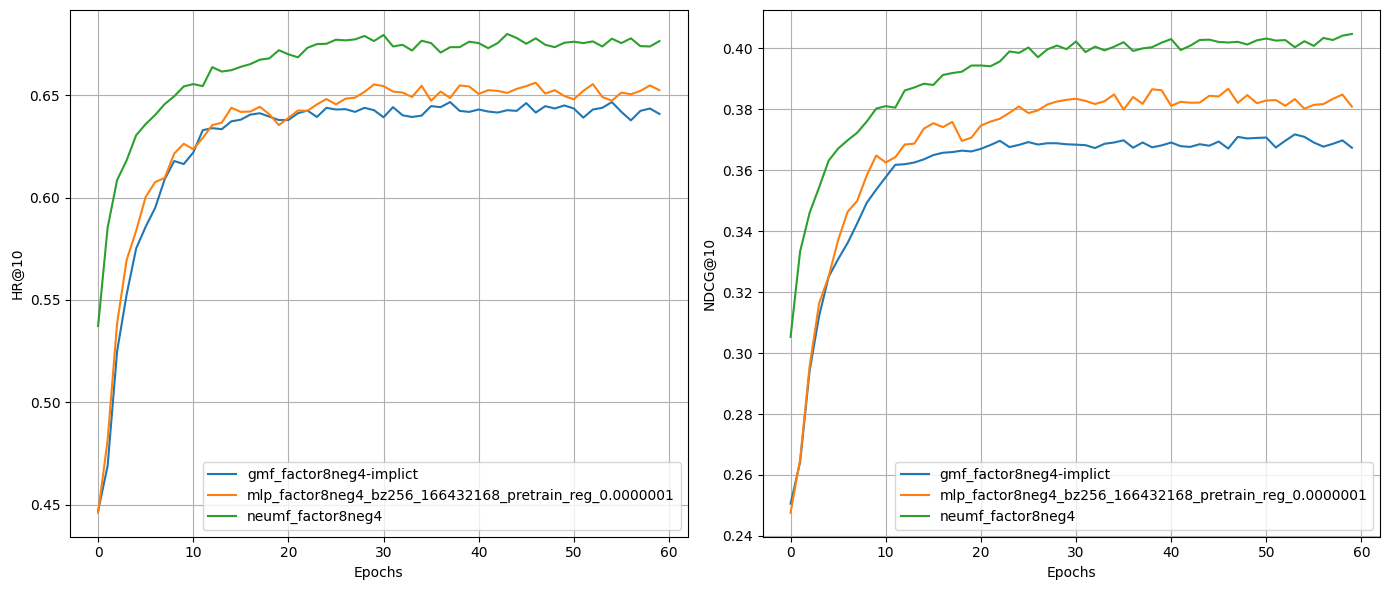

In [17]:
# 生成对比图的函数
def plot_results(results_dict):
    plt.figure(figsize=(14, 6))

    for model, data in results_dict.items():
        epochs = data['epochs']
        hr = data['hr']
        ndcg = data['ndcg']
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, hr, label=model)
        plt.xlabel('Epochs')
        plt.ylabel('HR@10')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, ndcg, label=model)
        plt.xlabel('Epochs')
        plt.ylabel('NDCG@10')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_results(results)

In [15]:
torch.cuda.is_available()

True

##### 消融实验

In [16]:
# 不同层数的MLP模型配置
mlp_configs = [
    {
        'layers': [16, 64, 32, 16, 8],
        'alias': 'mlp_4layers',
        'num_epoch': 20,
        'batch_size': 256,
        'optimizer': 'adam',
        'adam_lr': 1e-3,
        'num_users': 6040,
        'num_items': 3706,
        'latent_dim': 8,
        'num_negative': 4,
        'l2_regularization': 0.0000001,
        'weight_init_gaussian': True,
        'use_cuda': torch.cuda.is_available(), 
        'device_id': 0,
        'pretrain': False,
        'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model'),
        'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
    },
    {
        'layers': [16, 32, 16, 8],
        'alias': 'mlp_3layers',
        'num_epoch': 20,
        'batch_size': 256,
        'optimizer': 'adam',
        'adam_lr': 1e-3,
        'num_users': 6040,
        'num_items': 3706,
        'latent_dim': 8,
        'num_negative': 4,
        'l2_regularization': 0.0000001,
        'weight_init_gaussian': True,
        'use_cuda': torch.cuda.is_available(), 
        'device_id': 0,
        'pretrain': False,
        'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model'),
        'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
    },
    {
        'layers': [16, 16, 8],
        'alias': 'mlp_2layers',
        'num_epoch': 20,
        'batch_size': 256,
        'optimizer': 'adam',
        'adam_lr': 1e-3,
        'num_users': 6040,
        'num_items': 3706,
        'latent_dim': 8,
        'num_negative': 4,
        'l2_regularization': 0.0000001,
        'weight_init_gaussian': True,
        'use_cuda': torch.cuda.is_available(),  
        'device_id': 0,
        'pretrain': False,
        'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model'),
        'model_dir': 'checkpoints/{}_Epoch{}_HR{:.4f}_NDCG{:.4f}.model'
    }
]

In [17]:
for config in mlp_configs:
    engine = MLPEngine(config)
    
    model_dir = os.path.dirname(config['model_dir'])
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    for epoch in range(config['num_epoch']):
        print('Epoch {} starts !'.format(epoch))
        print('-' * 80)
        train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
        engine.train_an_epoch(train_loader, epoch_id=epoch)
        hit_ratio, ndcg = engine.evaluate(evaluate_data, epoch_id=epoch)
        engine.save(config['alias'], epoch, hit_ratio, ndcg)
        record_results(config['alias'], epoch, hit_ratio, ndcg, results)

MLP(
  (embedding_user): Embedding(6040, 8)
  (embedding_item): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=8, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))
/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 0] HR = 0.4442, NDCG = 0.2470
Epoch 1 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 1] HR = 0.4834, NDCG = 0.2676
Epoch 2 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 2] HR = 0.5371, NDCG = 0.2941
Epoch 3 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 3] HR = 0.5725, NDCG = 0.3189
Epoch 4 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 4] HR = 0.5930, NDCG = 0.3333
Epoch 5 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 5] HR = 0.6031, NDCG = 0.3397
Epoch 6 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 6] HR = 0.6177, NDCG = 0.3528
Epoch 7 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 7] HR = 0.6202, NDCG = 0.3548
Epoch 8 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 8] HR = 0.6209, NDCG = 0.3571
Epoch 9 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 9] HR = 0.6245, NDCG = 0.3601
Epoch 10 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 10] HR = 0.6260, NDCG = 0.3615
Epoch 11 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 11] HR = 0.6288, NDCG = 0.3657
Epoch 12 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 12] HR = 0.6308, NDCG = 0.3677
Epoch 13 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 13] HR = 0.6272, NDCG = 0.3669
Epoch 14 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 14] HR = 0.6353, NDCG = 0.3691
Epoch 15 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 15] HR = 0.6293, NDCG = 0.3672
Epoch 16 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 16] HR = 0.6329, NDCG = 0.3686
Epoch 17 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 17] HR = 0.6339, NDCG = 0.3685
Epoch 18 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 18] HR = 0.6348, NDCG = 0.3695
Epoch 19 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 19] HR = 0.6411, NDCG = 0.3747
MLP(
  (embedding_user): Embedding(6040, 8)
  (embedding_item): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=8, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 0] HR = 0.4490, NDCG = 0.2474
Epoch 1 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 1] HR = 0.4765, NDCG = 0.2633
Epoch 2 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 2] HR = 0.5204, NDCG = 0.2866
Epoch 3 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 3] HR = 0.5609, NDCG = 0.3123
Epoch 4 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 4] HR = 0.5732, NDCG = 0.3209
Epoch 5 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 5] HR = 0.5906, NDCG = 0.3286
Epoch 6 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 6] HR = 0.5952, NDCG = 0.3340
Epoch 7 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 7] HR = 0.6046, NDCG = 0.3393
Epoch 8 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 8] HR = 0.6063, NDCG = 0.3419
Epoch 9 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 9] HR = 0.6079, NDCG = 0.3472
Epoch 10 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 10] HR = 0.6127, NDCG = 0.3512
Epoch 11 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 11] HR = 0.6187, NDCG = 0.3550
Epoch 12 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 12] HR = 0.6224, NDCG = 0.3575
Epoch 13 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 13] HR = 0.6227, NDCG = 0.3571
Epoch 14 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 14] HR = 0.6281, NDCG = 0.3606
Epoch 15 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 15] HR = 0.6290, NDCG = 0.3613
Epoch 16 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 16] HR = 0.6286, NDCG = 0.3606
Epoch 17 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 17] HR = 0.6333, NDCG = 0.3637
Epoch 18 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 18] HR = 0.6295, NDCG = 0.3608
Epoch 19 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 19] HR = 0.6326, NDCG = 0.3627
MLP(
  (embedding_user): Embedding(6040, 8)
  (embedding_item): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=8, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 0] HR = 0.4497, NDCG = 0.2501
Epoch 1 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 1] HR = 0.4573, NDCG = 0.2521
Epoch 2 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 2] HR = 0.4914, NDCG = 0.2732
Epoch 3 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 3] HR = 0.5151, NDCG = 0.2865
Epoch 4 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 4] HR = 0.5406, NDCG = 0.2966
Epoch 5 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 5] HR = 0.5566, NDCG = 0.3097
Epoch 6 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 6] HR = 0.5675, NDCG = 0.3151
Epoch 7 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 7] HR = 0.5750, NDCG = 0.3214
Epoch 8 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 8] HR = 0.5836, NDCG = 0.3276
Epoch 9 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 9] HR = 0.5907, NDCG = 0.3326
Epoch 10 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 10] HR = 0.5916, NDCG = 0.3348
Epoch 11 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 11] HR = 0.5955, NDCG = 0.3382
Epoch 12 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 12] HR = 0.6030, NDCG = 0.3416
Epoch 13 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 13] HR = 0.6022, NDCG = 0.3417
Epoch 14 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 14] HR = 0.6083, NDCG = 0.3458
Epoch 15 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 15] HR = 0.6041, NDCG = 0.3429
Epoch 16 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 16] HR = 0.6106, NDCG = 0.3467
Epoch 17 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 17] HR = 0.6088, NDCG = 0.3492
Epoch 18 starts !
--------------------------------------------------------------------------------


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1
/tmp/ipykernel_69/557034335.py:57: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))


[Evaluating Epoch 18] HR = 0.6073, NDCG = 0.3480
Epoch 19 starts !
--------------------------------------------------------------------------------
[Evaluating Epoch 19] HR = 0.6123, NDCG = 0.3506


/tmp/ipykernel_69/1296982704.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in_top_k['ndcg'] = test_in_top_k['rank'].apply(lambda x: math.log(2) / math.log(1 + x))  # the rank starts from 1


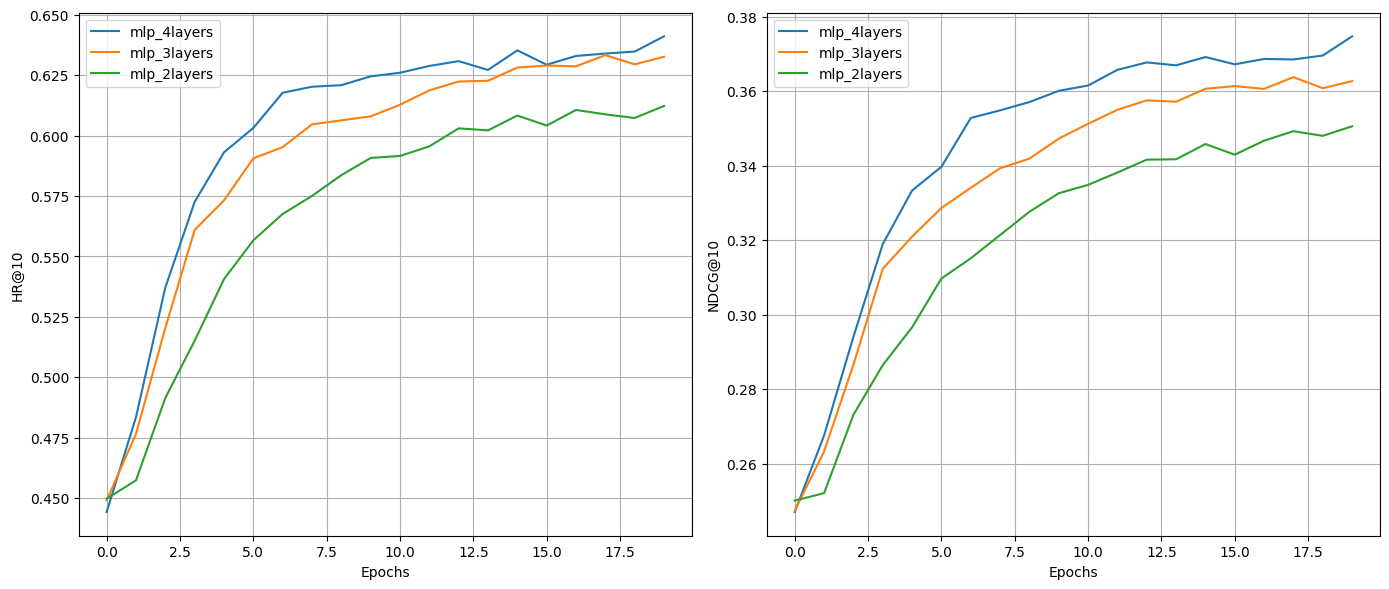

In [ ]:
def plot_results(results_dict):
    plt.figure(figsize=(14, 6))

    for model, data in results_dict.items():
        epochs = data['epochs']
        hr = data['hr']
        ndcg = data['ndcg']
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, hr, label=model)
        plt.xlabel('Epochs')
        plt.ylabel('HR@10')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, ndcg, label=model)
        plt.xlabel('Epochs')
        plt.ylabel('NDCG@10')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_results(results)